In [12]:
# Load the Datasets
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [13]:
default_batch_size = 64

In [14]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transform_cifar = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True, num_workers=2)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=default_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Print some of the CIFAR dataset samples if flag is set
print_sample = False
if print_sample:
    real_batch = next(iter(trainloader_cifar))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [16]:
class VAE_conv(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE_conv, self).__init__()
        channel_size = 32

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size * 2, channel_size * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(channel_size * 4 * 4 * 4, latent_size * 2)  # Adjusted for mu and log_var
        ).to(default_device)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, channel_size * 4 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (channel_size * 4, 4, 4)),
            nn.ConvTranspose2d(channel_size * 4, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size * 2, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        ).to(default_device)

        # Latent space
        self.fc_mu = nn.Linear(hidden_size, latent_size).to(default_device)
        self.fc_log_var = nn.Linear(hidden_size, latent_size).to(default_device)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)  # Split into mu and log_var

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        x_recon = self.decoder(z)

        return x_recon, mu, log_var
    
def vae_loss_function_conv(recon_x, x, mu, log_var):
    # Flatten recon_x to match the shape of x
    recon_x_flat = recon_x.view(x.size())

    BCE = nn.functional.binary_cross_entropy(recon_x_flat, x, reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return (BCE, KLD)

In [17]:
def train_vae_conv(model, trainloader, optimizer, num_epochs, input_size):
    BCE_loss = []
    KLD_loss = []
    total_loss = []

    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(default_device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Reshape the inputs for the loss function
            inputs_flat = inputs.view(-1, 3, 32, 32)
            recon_batch_flat = recon_batch.view(-1, 3, 32, 32)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function_conv(recon_batch_flat, inputs, mu, log_var)
            loss = BCE + KLD

            BCE_loss.append(BCE.item()/input_size)
            KLD_loss.append(KLD.item()/input_size)
            total_loss.append(loss.item()/input_size)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            if i % 1000 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item()/input_size, KLD.item()/input_size, loss.item()/input_size))
    return BCE_loss, KLD_loss, total_loss

In [18]:
# CIFAR 10 Data Training - Conv
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
hidden_size = 512 # Hidden size for hidden layer ** relationship in the cnn architecture so can't just change this
latent_size = 2 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 15 # Number of epochs to train for

# CNN

# Initialize the model
vae_model_cifar = VAE_conv(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_cifar.parameters(), lr=learning_rate)

# Train the model
BCE_loss, KLD_loss, total_loss = train_vae_conv(vae_model_cifar, trainloader_cifar, optimizer, num_epochs, input_size)

Epoch [1/15], Step [1/782], BCE: 44.2625, KLD: 0.0000, Total Loss: 44.2626
Epoch [2/15], Step [1/782], BCE: 40.6710, KLD: 0.1102, Total Loss: 40.7812
Epoch [3/15], Step [1/782], BCE: 41.2582, KLD: 0.1056, Total Loss: 41.3638
Epoch [4/15], Step [1/782], BCE: 40.5390, KLD: 0.1110, Total Loss: 40.6500
Epoch [5/15], Step [1/782], BCE: 40.2580, KLD: 0.1125, Total Loss: 40.3705
Epoch [6/15], Step [1/782], BCE: 41.0977, KLD: 0.1079, Total Loss: 41.2056
Epoch [7/15], Step [1/782], BCE: 41.2871, KLD: 0.1120, Total Loss: 41.3991
Epoch [8/15], Step [1/782], BCE: 40.6625, KLD: 0.1119, Total Loss: 40.7744
Epoch [9/15], Step [1/782], BCE: 40.1278, KLD: 0.1192, Total Loss: 40.2470
Epoch [10/15], Step [1/782], BCE: 40.2878, KLD: 0.1188, Total Loss: 40.4065
Epoch [11/15], Step [1/782], BCE: 39.9449, KLD: 0.1225, Total Loss: 40.0675
Epoch [12/15], Step [1/782], BCE: 40.6496, KLD: 0.1147, Total Loss: 40.7644
Epoch [13/15], Step [1/782], BCE: 40.8208, KLD: 0.1202, Total Loss: 40.9410
Epoch [14/15], Step [

## Plot the Results

Text(0, 0.5, 'Loss')

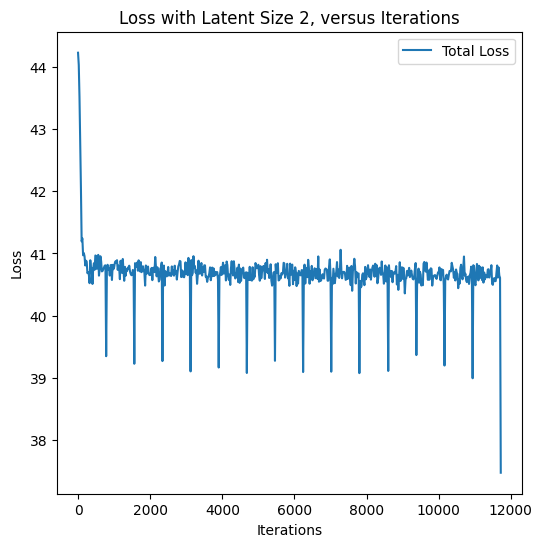

In [19]:
# Plot the losses
number_bins = 20

# Bin the discriminator losses and calculate the averages
binned_BCE_loss = [np.mean(BCE_loss[i:i + number_bins]) for i in range(0, len(BCE_loss), number_bins)]
binned_KLD_loss = [np.mean(KLD_loss[i:i + number_bins]) for i in range(0, len(KLD_loss), number_bins)]
binned_total_loss = [np.mean(total_loss[i:i + number_bins]) for i in range(0, len(total_loss), number_bins)]

plt.figure(figsize=(6, 6))
# plt.subplot(1, 3, 1)
# plt.plot(range(0, len(BCE_loss), number_bins), binned_BCE_loss, label='BCE Loss')

# plt.legend()
# plt.title('Binary Cross Entropy Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')

plt.plot(range(0, len(total_loss), number_bins), binned_total_loss, label='Total Loss')
plt.legend()
plt.title(f'Loss with Latent Size {latent_size}, versus Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# plt.subplot(1, 3, 3)
# plt.plot(range(0, len(KLD_loss), number_bins), binned_KLD_loss, label='KLD Loss')
# plt.legend()
# plt.title('KL Divergence')
# plt.xlabel('Iterations')
# plt.ylabel('Loss'))

C:\Users\Nathan\AppData\Local\Temp\ipykernel_17756\3540165302.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(np.transpose(vutils.make_grid(torch.tensor(real_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))


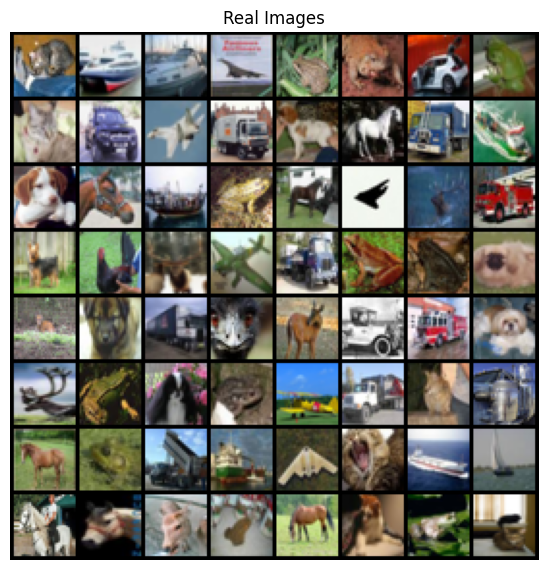

C:\Users\Nathan\AppData\Local\Temp\ipykernel_17756\3540165302.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(np.transpose(vutils.make_grid(torch.tensor(recon_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))


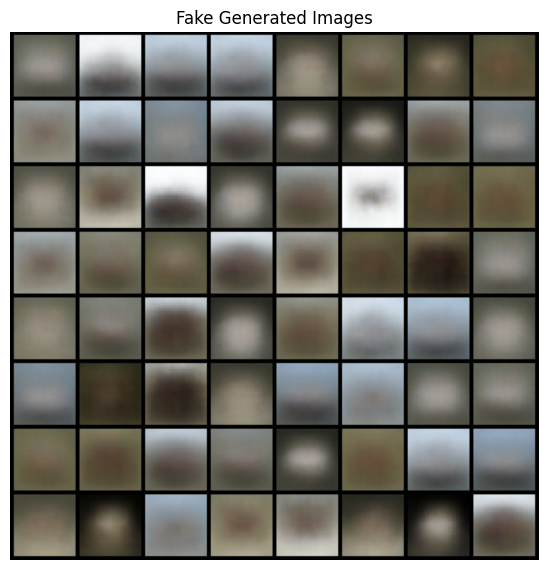

In [20]:
import torchvision
import torchvision.transforms as transforms

num_rows = 10
vae_model_cifar.eval()

with torch.no_grad():
    # Get a batch of real images
    real_images, _ = next(iter(testloader_cifar))
    real_images = real_images.to(default_device)

    # Generate images using the VAE
    recon_images, _, _ = vae_model_cifar(real_images)

# Plot the fake images from the last epoch
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(real_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Generated Images")
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(recon_images[:default_batch_size]).to(default_device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

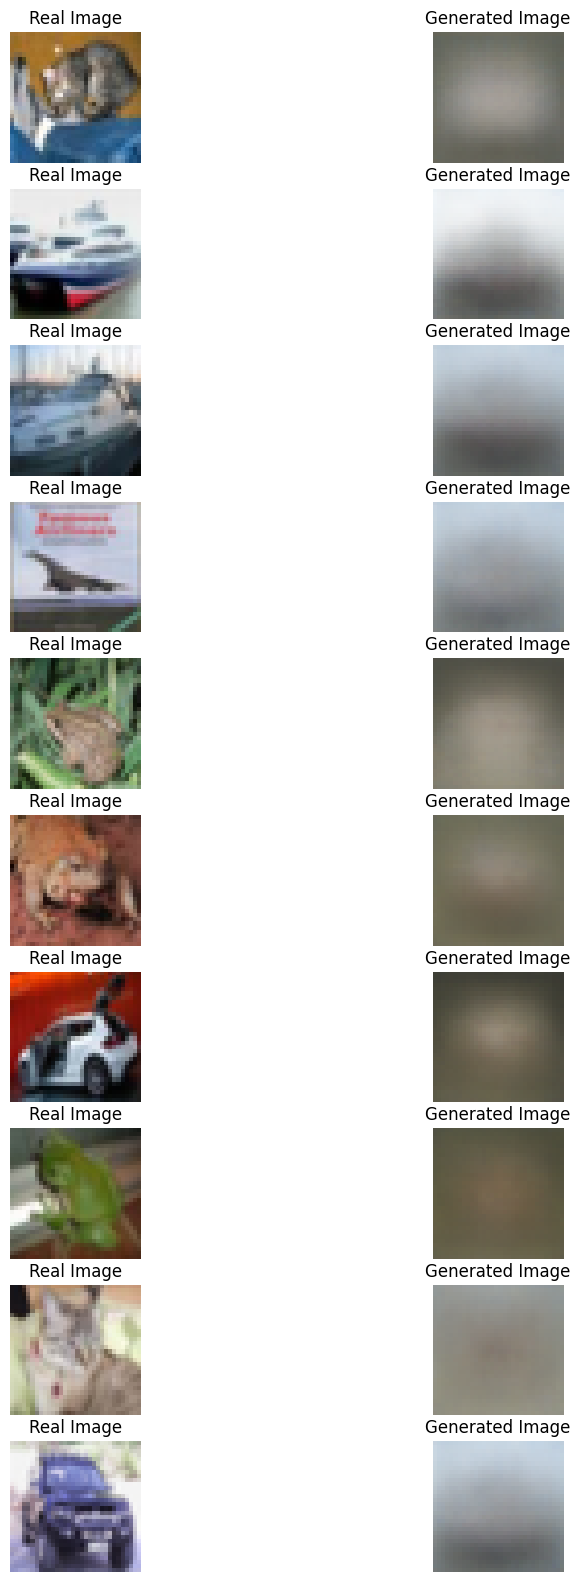

In [21]:
# Side by side image comparison

import torchvision
import torchvision.transforms as transforms

num_rows = 10
vae_model_cifar.eval()

with torch.no_grad():
    # Get a batch of real images
    real_images, _ = next(iter(testloader_cifar))
    real_images = real_images.to(default_device)

    # Generate images using the VAE
    recon_images, _, _ = vae_model_cifar(real_images)

# Display the images
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 2 * num_rows))
for i in range(num_rows):
    # Display real images
    axes[i, 0].imshow(torchvision.utils.make_grid(real_images[i].cpu(), nrow=1).permute(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Real Image')

    # Display generated images
    axes[i, 1].imshow(torchvision.utils.make_grid(recon_images[i].cpu(), nrow=1).permute(1, 2, 0))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Generated Image')

plt.show()